In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# set fresh env per https://mapreader.readthedocs.io/en/latest/Install.html
import os, sys
sys.path.append('../scripts/')
import mapreader
import cartopy

In [3]:
# load map tif paths
from mapreader import loader
my_files = loader("../content/tifs/*.tif")
my_files.add_geo_info() # if pre georeferenced may need to set: target_crs 
print(my_files)

  0%|          | 0/1 [00:00<?, ?it/s]

#images: 1

#parents: 1
189226695.27_clip.tif

#patches: 0



### Patchify

In [25]:
# set directory & patch size (pixels unless -- method="meters" )
my_files.patchify_all(path_save="../content/tifs/patches/", patch_size=500)

[INFO] Saving patches in directory named "../content/tifs/patches/".


  0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
parent_list = my_files.list_parents()
patch_list = my_files.list_patches()

print(parent_list)
print(patch_list[0:5])  # too many to print them all!

['189226695.27_clip.tif']
['patch-0-0-500-500-#189226695.27_clip.tif#.png', 'patch-0-500-500-1000-#189226695.27_clip.tif#.png', 'patch-0-1000-500-1500-#189226695.27_clip.tif#.png', 'patch-0-1500-500-2000-#189226695.27_clip.tif#.png', 'patch-0-2000-500-2500-#189226695.27_clip.tif#.png']


In [13]:
# save patches in memory as geotiffs 
my_files.save_patches_as_geotiffs()

  0%|          | 0/432 [00:00<?, ?it/s]

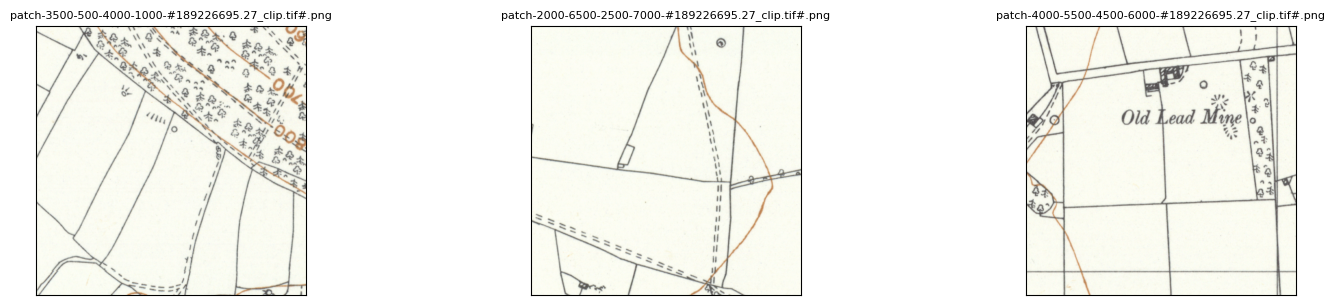

In [30]:
# take a random sample of 3 patches
my_files.show_sample(num_samples=3, tree_level="patch")

  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 1 Axes>]

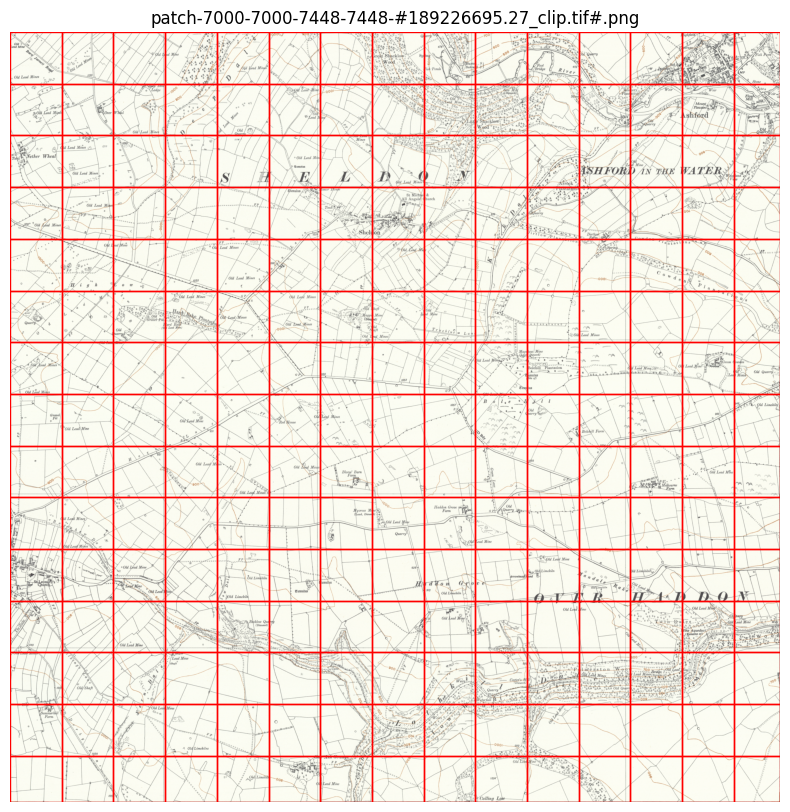

In [28]:
parent_list = my_files.list_parents()
my_files.show_parent(parent_list[0])